## 建模与调优

**实验任务：**训练决策树模型预测泰坦尼克号乘客数据集中乘客生存情况，并做超参数调优

**实验课时：**2课时

**实验目的：**

* 了解建模与调优在机器学习中的作用；
* 理解交叉验证和超参数调优的相关概念；
* 掌握交叉验证超参数调优的实现方法；
* 掌握决策树建模的实现方法。

载入需要用到的程序包。

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pydotplus import graph_from_dot_data
import graphviz
from IPython.display import Image 
pd.set_option('mode.chained_assignment',None)
plt.rcParams['font.sans-serif']=['SimHei']

In [53]:
titanic3_file_path="./titanic3.xls"
titanic3 = pd.read_excel(titanic3_file_path)
titanic3.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


随机划分训练集和测试集。

In [54]:
X = titanic3[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
y = titanic3['survived']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 123)

填充训练集和测试集的缺失值。

In [55]:
imp = SimpleImputer(strategy='median')
train_X[['age','fare']] = imp.fit_transform(train_X[['age','fare']])
test_X[['age','fare']] = imp.transform(test_X[['age','fare']])

做训练集和测试集的独热编码。

In [56]:
categorical_cols = ['pclass','sex','embarked']
numeric_cols = list(set(X.columns) - set(categorical_cols))
ohe = OneHotEncoder(drop = 'first', sparse = False)
train_X = np.hstack((ohe.fit_transform(train_X[categorical_cols]), train_X[numeric_cols]))
cols = ["pclass_2nd","pclass_3rd","sex_male","embarked_Queenstown","embarked_Southampton","embarked_Unknown","sibsp","fare","age","parch"]
train_X = pd.DataFrame(train_X, columns = cols)
test_X = np.hstack((ohe.transform(test_X[categorical_cols]), test_X[numeric_cols]))
test_X = pd.DataFrame(test_X, columns = cols)
train_X.head(10)

,pclass_2nd,pclass_3rd,sex_male,embarked_Queenstown,embarked_Southampton,embarked_Unknown,sibsp,fare,age,parch
0,0.0,0.0,1.0,0.0,0.0,0.0,35.0,0.0,0.0,26.5500
1,0.0,1.0,1.0,0.0,1.0,0.0,30.0,0.0,1.0,16.1000
2,0.0,1.0,0.0,0.0,1.0,0.0,36.0,0.0,1.0,17.4000
3,0.0,1.0,1.0,0.0,0.0,0.0,26.0,0.0,0.0,18.7875
4,0.0,1.0,1.0,0.0,1.0,0.0,41.0,0.0,2.0,14.1083
5,0.0,0.0,1.0,0.0,1.0,0.0,27.0,0.0,0.0,39.6000
6,0.0,0.0,1.0,0.0,1.0,0.0,60.0,0.0,0.0,26.5500
7,0.0,1.0,0.0,0.0,1.0,0.0,9.0,2.0,2.0,34.3750
8,0.0,1.0,1.0,0.0,1.0,0.0,27.0,0.0,0.0,7.5500
9,1.0,0.0,1.0,0.0,0.0,0.0,27.0,0.0,0.0,13.8625


这里为了解释之后的交叉验证概念，得到将变量survived排序后的行索引。

### 1. 交叉验证

之前章节已经介绍了将数据集划分为训练集和测试集的方法。对于每一种模型，都有一系列超参数，即需要在训练模型前人工指定的模型参数，如决策树的最大深度。如果使用测试集评估哪一组超参数性能最好会有过拟合的风险，因为测试集的信息会在这一过程中“泄露”到模型中去，使得测试集的性能无法代表泛化性能。我们会进一步将训练集划分成训练集和验证集，使用验证集多次模型进行评估并进而做出选择。

然而，将数据集划分为训练集、验证集和测试集，会使得训练样本显著减少。解决方法就是交叉验证（cross-validation，CV），最常用的方法是k折交叉验证。将数据集划分成$k$个大小相似的互斥子集，每次用$k-1$个子集的并集作为训练集，余下的那个子集作为验证集，从而进行$k$次训练和验证，最终返回的是这$k$个验证集结果的均值，如下图所示（$k=5$）.

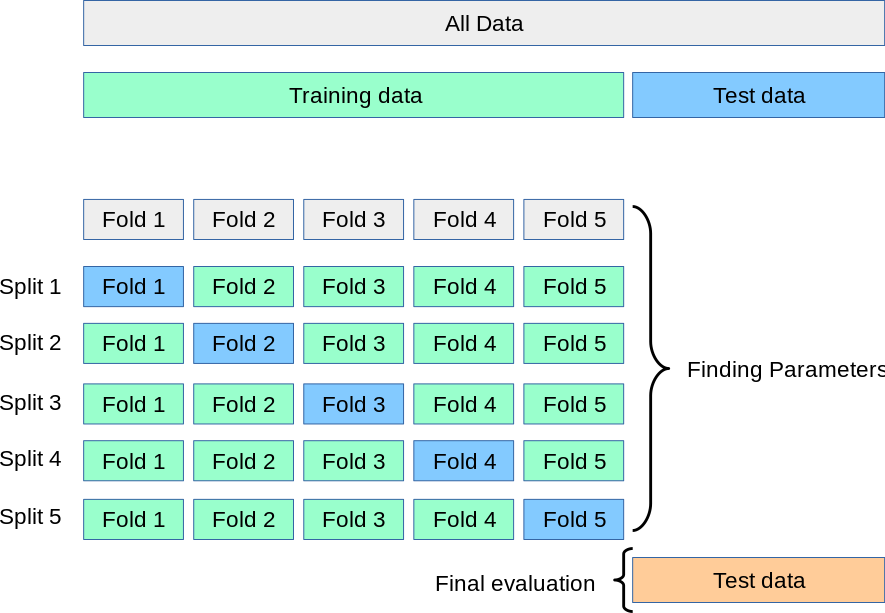

程序包`sklearn.model_selection`中有多种k折交叉验证迭代器，主要包括：

* 构造函数`KFold()`表示k折交叉验证迭代器；
* 构造函数`StratifiedKFold()`表示分层k折交叉验证迭代器，即分层变量（通常是因变量）的数值分布在训练集和测试机中保持一致。

常用参数主要包括：

* 第1个参数`n_splits`表示交叉验证中的折数；
* 第2个参数`shuffle `表示是否需要打乱样本顺序，默认为否；
* 第3个参数`random_state`表示随机数种子。

这里定义一个不打乱样本顺序的3折交叉验证迭代器。

In [57]:
kf = KFold(n_splits=3, shuffle=False)

调用k折交叉验证迭代器的函数`split()`得到每次迭代的训练集和验证集的索引。这里定义一个90个样本的样例数据集做展示，对象`X`表示自变量，对象`y`表示因变量（前30个为类别0，后60个为类别1）。

In [58]:
X = np.array([0] * 90); y = np.array([0] * 30 + [1] * 60)
[(train, valid) for train, valid in kf.split(X)]

[(array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
         47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
         64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
         81, 82, 83, 84, 85, 86, 87, 88, 89]),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 60, 61, 62, 63,
         64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
         81, 82, 83, 84, 85, 86, 87, 88, 89]),
  array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
         47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        

为了更直观感受不同交叉验证方法划分训练集的具体情况，这里绘制每次划分迭代的样本索引。

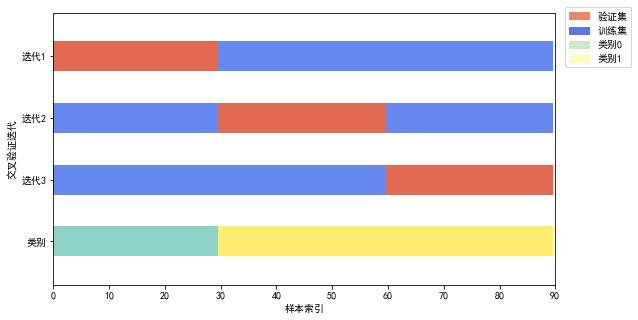

In [59]:
fig, ax = plt.subplots(figsize = (9,5))
for i, (train, valid) in enumerate(kf.split(X)):
    indices = np.zeros(len(X))
    indices[valid] = 1
    plt.scatter(range(len(indices)), [i + .5] * len(indices), c=indices, marker='_', lw=30, cmap=plt.cm.coolwarm, vmin=-.2, vmax=1.2)

plt.scatter(range(len(X)), [i + 1.5] * len(X), c=y, marker='_', lw=30, cmap=plt.cm.Set3)
ax.set(yticks=np.arange(4) + .5, yticklabels=["迭代"+str(i+1) for i in range(3)] + ["类别"],
       xlabel='样本索引', ylabel="交叉验证迭代",
       ylim=[4.2, -.2], xlim=[0, 90])
ax.legend([Patch(color=plt.cm.coolwarm(.8)), Patch(color=plt.cm.coolwarm(.1)), 
           Patch(color=plt.cm.Set3(.87)), Patch(color=plt.cm.Set3(.1))], 
          ['验证集', '训练集', '类别0', '类别1'], loc=(1.02, .8))
plt.show()

可以看出，3次迭代每次都有1/3样本作为验证集，且样本顺序没有打乱。

这里再定义一个打乱样本顺序的3折交叉验证迭代器，并绘制每次划分迭代的样本索引。

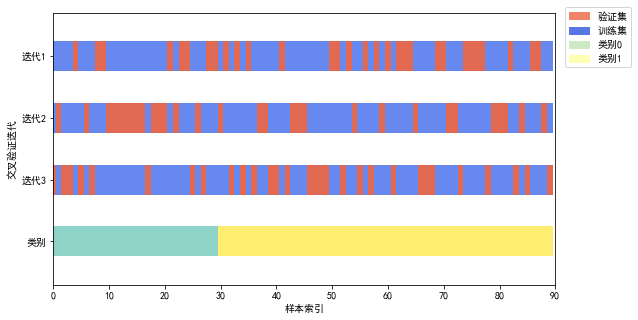

In [60]:
kf = KFold(n_splits=3, shuffle=True, random_state=123)
fig, ax = plt.subplots(figsize = (9,5))
for i, (train, valid) in enumerate(kf.split(X)):
    indices = np.zeros(len(X))
    indices[valid] = 1
    plt.scatter(range(len(indices)), [i + .5] * len(indices), c=indices, marker='_', lw=30, cmap=plt.cm.coolwarm, vmin=-.2, vmax=1.2)

plt.scatter(range(len(X)), [i + 1.5] * len(X), c=y, marker='_', lw=30, cmap=plt.cm.Set3)
ax.set(yticks=np.arange(4) + .5, yticklabels=["迭代"+str(i+1) for i in range(3)] + ["类别"],
       xlabel='样本索引', ylabel="交叉验证迭代",
       ylim=[4.2, -.2], xlim=[0, 90])
ax.legend([Patch(color=plt.cm.coolwarm(.8)), Patch(color=plt.cm.coolwarm(.1)), 
           Patch(color=plt.cm.Set3(.87)), Patch(color=plt.cm.Set3(.1))], 
          ['验证集', '训练集', '类别0', '类别1'], loc=(1.02, .8))
plt.show()

这里再定义一个不打乱样本顺序的分层3折交叉验证迭代器，并绘制每次划分迭代的样本索引。

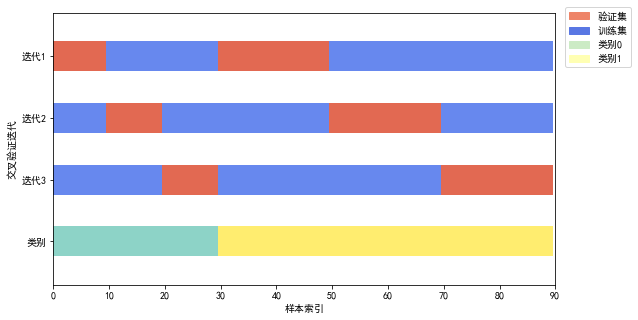

In [61]:
skf = StratifiedKFold(n_splits=3, shuffle=False)
fig, ax = plt.subplots(figsize = (9,5))
for i, (train, valid) in enumerate(skf.split(X, y)):
    indices = np.zeros(len(X))
    indices[valid] = 1
    plt.scatter(range(len(indices)), [i + .5] * len(indices), c=indices, marker='_', lw=30, cmap=plt.cm.coolwarm, vmin=-.2, vmax=1.2)

plt.scatter(range(len(X)), [i + 1.5] * len(X), c=y, marker='_', lw=30, cmap=plt.cm.Set3)
ax.set(yticks=np.arange(4) + .5, yticklabels=["迭代"+str(i+1) for i in range(3)] + ["类别"],
       xlabel='样本索引', ylabel="交叉验证迭代",
       ylim=[4.2, -.2], xlim=[0, 90])
ax.legend([Patch(color=plt.cm.coolwarm(.8)), Patch(color=plt.cm.coolwarm(.1)), 
           Patch(color=plt.cm.Set3(.87)), Patch(color=plt.cm.Set3(.1))], 
          ['验证集', '训练集', '类别0', '类别1'], loc=(1.02, .8))
plt.show()

除了最常用的k折交叉验证，还有余p交叉验证法（leave-p-out），每次迭代仅有$p$个样本作为验证集，可以通过程序包`sklearn.model_selection`的构造函数`LeavePOut()`定义，第1个参数`p`表示每次迭代验证集样本数。特别的极端情况为$p=1$，即余一交叉验证，可以通过程序包`sklearn.model_selection`的构造函数`LeaveOneOut()`定义.

### 2. 超参数调优

机器学习建模有多种任务，包括分类预测、回归预测和聚类分析等等。每种任务又都有多种模型，如对于分类任务，有决策树、随机森林、支持向量机和人工神经网络等等。这里我们以分类预测中的决策树模型为例，做超参数调优。

这里调用程序包`sklearn.tree`中的构造函数`DecisionTreeClassifier()`创建决策树模型，之后章节会具体介绍。

In [62]:
clf = DecisionTreeClassifier()

对于每一种模型，都有一系列超参数，即需要在训练模型前人工指定的模型参数。

调用模型对象的函数`get_params()`得到超参数列表和每个超参数的默认值。

In [63]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

对于具体问题，无法事先明确知道哪一组超参数会取得最佳效果，因此需要做超参数调优得到最佳的超参数组合。

定义字典`param_grid`表示需要调优的超参数及尝试的数值。

这里调优的超参数范围为

* 最大深度（`max_depth`）：3、4和5；
* 最小掺杂度减少比例（`min_impurity_decrease`）：0.001和0.005。

In [64]:
param_grid = {'max_depth': [3,4,5], 'min_impurity_decrease': [0.001,0.005]}

超参数调优有多种调优算法选择。在程序包`sklearn.model_selection`中对应了不同函数定义不同调优算法，主要包括：

* 构造函数`GridSearchCV()`表示网格搜索；
* 构造函数`RandomizedSearchCV()`表示随机搜索。

调用程序包`sklearn.model_selection`中的构造函数`GridSearchCV()`创建网格搜索超参数调优器，其中

* 第1个参数`estimator`表示机器学习模型；
* 第2个参数`param_grid`表示超参数搜索范围的字典；
* 第3个参数`scoring`表示模型性能指标，分类任务的常用指标包括（具体细节在后续章节介绍）：
    - `'accuracy'`表示精度；
    - `'roc_auc'`表示ROC曲线下面积；
    - `'f1'`表示F1分数；
    - `'precision'`表示查准率；
    - `'recall'`表示查全率；
* 参数`cv`表示交叉验证策略，常用的值包括
    - `None`表示默认的5折交叉验证；
    - 整数型表示k折交叉验证中的折数；
    - 交叉验证迭代器对象；
    - 可迭代的训练集合测试集划分。

这里我们调优决策树的模型的2个超参数，模型性能指标为精度，交叉验证策略为打乱样本顺序的3折交叉验证。

In [65]:
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv = kf)

调用网格搜索超参数调优器的函数`fit()`做超参数调优，输入参数为训练集的自变量和因变量Numpy数组。使用网格搜索超参数调优器的属性`cv_results_`得到超参数调优结果。

In [66]:
gs.fit(train_X, train_y)
cv_results = pd.DataFrame(gs.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_impurity_decrease,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003989,1.627036e-03,0.001662,4.701915e-04,3,0.001,"{'max_depth': 3, 'min_impurity_decrease': 0.001}",0.836601,0.786885,0.796721,0.806736,0.021496,2
1,0.002655,4.711017e-04,0.001331,4.699093e-04,3,0.005,"{'max_depth': 3, 'min_impurity_decrease': 0.005}",0.836601,0.786885,0.800000,0.807829,0.021038,1
2,0.002327,4.702465e-04,0.001663,4.698532e-04,4,0.001,"{'max_depth': 4, 'min_impurity_decrease': 0.001}",0.803922,0.750820,0.773770,0.776171,0.021745,6
3,0.002659,4.701911e-04,0.000997,7.370010e-07,4,0.005,"{'max_depth': 4, 'min_impurity_decrease': 0.005}",0.813725,0.786885,0.786885,0.795832,0.012653,3
4,0.001995,4.052337e-07,0.001329,4.714274e-04,5,0.001,"{'max_depth': 5, 'min_impurity_decrease': 0.001}",0.820261,0.754098,0.780328,0.784896,0.027203,5
5,0.002323,4.726889e-04,0.001334,4.759222e-04,5,0.005,"{'max_depth': 5, 'min_impurity_decrease': 0.005}",0.813725,0.786885,0.786885,0.795832,0.012653,3


仅保留超参数值、性能指标和排名，更加可读。

In [67]:
cv_results[['param_max_depth','param_min_impurity_decrease', 'mean_test_score','rank_test_score']]

,param_max_depth,param_min_impurity_decrease,mean_test_score,rank_test_score
0,3,0.001,0.806736,2
1,3,0.005,0.807829,1
2,4,0.001,0.776171,6
3,4,0.005,0.795832,3
4,5,0.001,0.784896,5
5,5,0.005,0.795832,3



可以看出，共需要搜索6组超参数组合，计算每组超参数的**验证集**平均精度，确定了最佳的超参数组合是最大深度（`max_depth`）为3且最小掺杂度减少比例（`min_impurity_decrease`）为0.005。

使用网格搜索超参数调优器的属性`best_estimator_`得到最优超参数组合的机器学习模型。

In [68]:
gs.best_estimator_

DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.005)

将超参数调优结果进行可视化，可以更直观看出趋势。

绘制超参数调优结果。

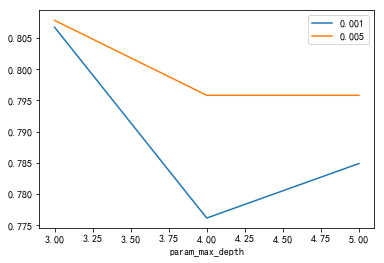

In [69]:
fig, ax = plt.subplots()
grouped = cv_results.groupby('param_min_impurity_decrease')
for key, group in grouped:
    group.plot(ax=ax, x='param_max_depth', y='mean_test_score', label=key)
plt.show()


可以看出，最小掺杂度减少比例（`min_impurity_decrease`）为0.005的性能好于0.001，且最大深度（`max_depth`）为3的性能好于4和5。

### 3. 训练模型

在选出了最优的超参数组合后，利用该组超参数和所有训练集数据训练模型。

调用决策树模型的函数`fit()`做训练，输入参数为训练集的自变量和因变量Numpy数组。

In [70]:
clf = gs.best_estimator_
clf.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.005)

这里得到的是一个决策树模型，可以绘制决策树进行直观感受。

调用程序包`sklearn.tree`中的函数`plot_tree()`绘制决策树，其中

* 第1个参数`decision_tree`表示决策树模型；
* 第2个参数`max_depth`表示绘制树的最大深度；
* 第3个参数`feature_names`表示特征变量名称；
* 参数`filled`表示是否按预测类别颜色填充；
* 参数`rounded`表示边框是否采用圆角。

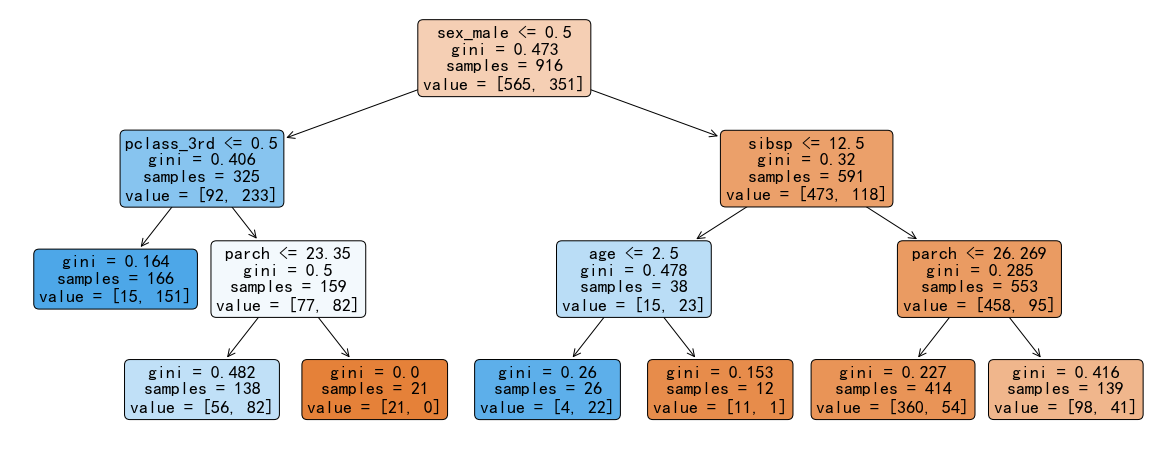

In [71]:
plt.figure(figsize = (20,8))
plot_tree(clf, feature_names=train_X.columns, filled=True, rounded=True)
plt.show()